### 표정 이미지 데이터를 통한 자페 스펙트럼 아동을 위한 표정 인지 학습 딥러닝

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pylab as plt

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
tf.__version__

'2.11.1'

In [3]:
# 경로 가져오기
train_path = './data/images/images/train/'
test_path = './data/images/images/validation/'

In [4]:
# RGB 255크기를 0~1로 스케일링
image_gen = ImageDataGenerator()
image_gen

In [5]:
# flow_from_directory 함수로 폴더에서 이미지를 가져와 제네레이터 객체로 정리
train_gen =image_gen.flow_from_directory(train_path,batch_size=128,
                                          color_mode='grayscale',
                                          target_size = (112,112),
                                          classes = ['angry','happy','sad'],
                                          class_mode = 'categorical',
                                          seed =2020)

valid_gen = image_gen.flow_from_directory(test_path,batch_size=128,
                                          color_mode='grayscale',
                                          target_size = (112,112),
                                          classes = ['angry','happy','sad'],
                                          class_mode = 'categorical',
                                          seed =2020)


Found 16095 images belonging to 3 classes.
Found 3924 images belonging to 3 classes.


In [6]:
# 라벨 - 원핫인코딩 확인
type(train_gen)
train_gen[0],train_gen[1]


((array([[[[ 43.],
           [ 43.],
           [ 17.],
           ...,
           [ 32.],
           [ 55.],
           [ 55.]],
  
          [[ 43.],
           [ 43.],
           [ 17.],
           ...,
           [ 32.],
           [ 55.],
           [ 55.]],
  
          [[ 75.],
           [ 75.],
           [ 54.],
           ...,
           [ 40.],
           [ 52.],
           [ 52.]],
  
          ...,
  
          [[ 13.],
           [ 13.],
           [  9.],
           ...,
           [ 11.],
           [ 16.],
           [ 16.]],
  
          [[  9.],
           [  9.],
           [  9.],
           ...,
           [ 18.],
           [ 14.],
           [ 14.]],
  
          [[  9.],
           [  9.],
           [  9.],
           ...,
           [ 18.],
           [ 14.],
           [ 14.]]],
  
  
         [[[165.],
           [165.],
           [156.],
           ...,
           [125.],
           [131.],
           [131.]],
  
          [[165.],
           [165.],
  

(128, 112, 112, 1) (128, 3)


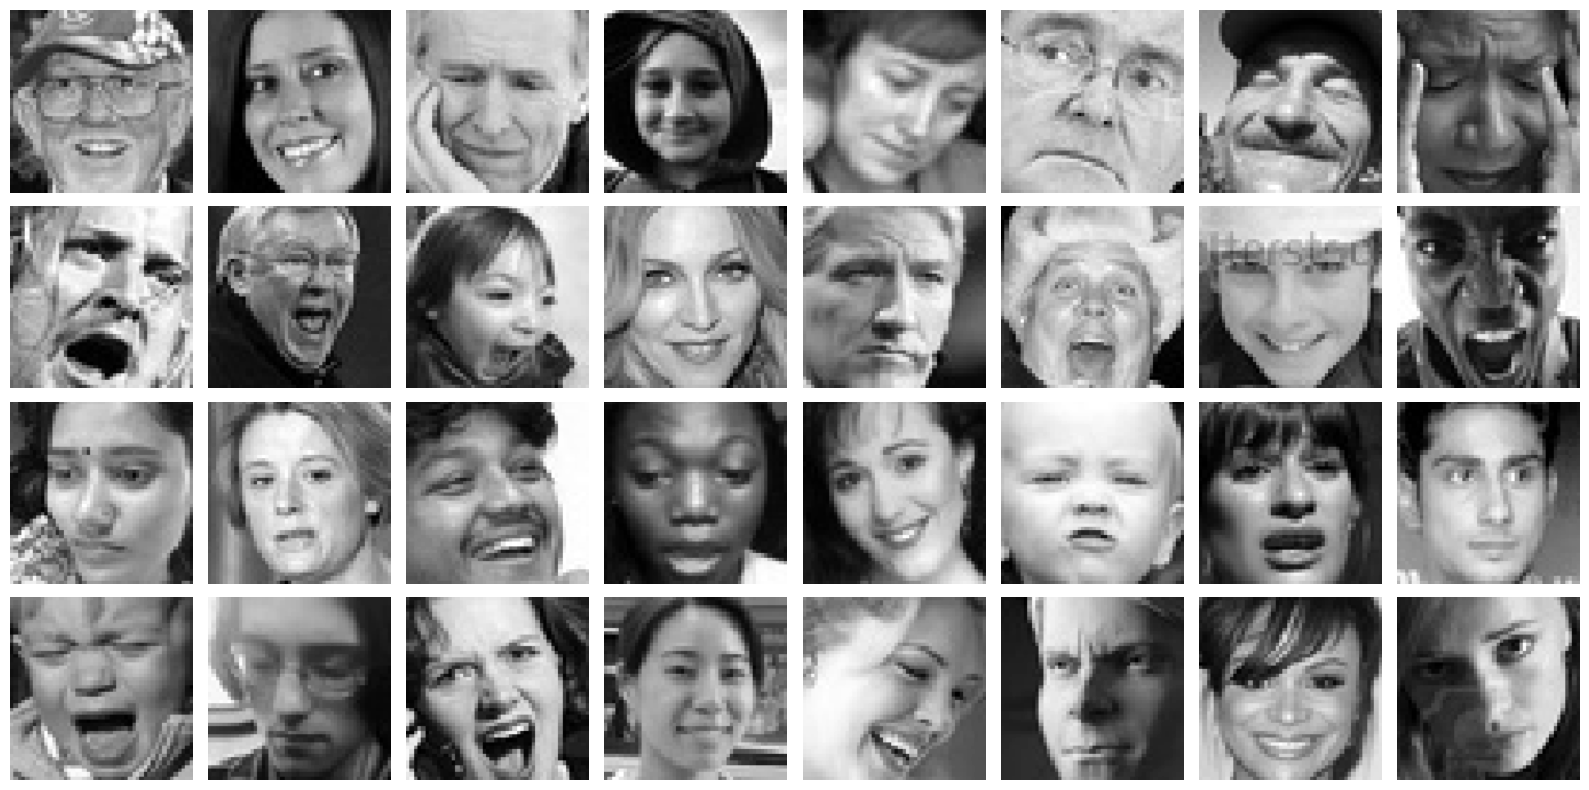

In [7]:
# 샘플 이미지 출력

class_labels = ['angry','happy','sad']
batch = next(train_gen)
images,labels = batch[0],batch[1]
print(images.shape,  labels.shape)

plt.figure(figsize=(16,8))
for i in range(32):
    ax = plt.subplot(4,8,i+1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
train_gen.image_shape, train_gen.labels, train_gen

((112, 112, 1),
 array([0, 0, 0, ..., 2, 2, 2]),
 <keras.preprocessing.image.DirectoryIterator at 0x2d45a83ed90>)

In [9]:
# 모델 구성

inputs = tf.keras.layers.Input(shape=(112, 112, 1),name='InputLayer')

# Convolution 층
x1 = tf.keras.layers.Conv2D(32,(3,3), padding='same', activation='leaky_relu')(inputs)
x2 = tf.keras.layers.BatchNormalization()(x1)
x3 = tf.keras.layers.MaxPooling2D((2,2))(x2)

x4 = tf.keras.layers.Conv2D(64,(5,5), padding='same', activation='relu')(x3)
x5 = tf.keras.layers.BatchNormalization()(x4)
x6 = tf.keras.layers.MaxPooling2D((2,2))(x5)

x7 = tf.keras.layers.Conv2D(128,(3,3), padding='same', activation='relu')(x6)
x8 = tf.keras.layers.BatchNormalization()(x7)
x9 = tf.keras.layers.MaxPooling2D((2,2))(x8)


# Classifier 출력층

x10 = tf.keras.layers.Flatten()(x9)
x11 = tf.keras.layers.Dense(256, kernel_initializer='he_normal',activation='relu')(x10)
x12 = tf.keras.layers.Dropout(0.5)(x11)

x13 = tf.keras.layers.Dense(512, activation='relu')(x12)
x14 = tf.keras.layers.Dropout(0.5)(x13)

x15 = tf.keras.layers.Dense(3,kernel_initializer='he_normal', activation='softmax')(x14)



In [10]:
# 모델 생성 및 summary
model = tf.keras.Model(inputs, x15,name="face_Expression")
model.summary()

Model: "face_Expression"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 112, 112, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 56, 56, 64)   

In [11]:
# 모델 컴파일
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])


In [13]:
%%time
# checkpoint 및 earlystopping 설정
checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


CPU times: total: 0 ns
Wall time: 0 ns


In [14]:
# 배치 생성
batch = next(train_gen)
images,labels = batch[0],batch[1]
images.shape, labels.shape, type(images), type(labels)

((128, 112, 112, 1), (128, 3), numpy.ndarray, numpy.ndarray)

In [15]:
# 모델 학습
history = model.fit(train_gen,
                    steps_per_epoch=train_gen.n//train_gen.batch_size,
                    epochs=50,
                    validation_data = valid_gen,
                    validation_steps = valid_gen.n//valid_gen.batch_size,
                    callbacks=[checkpoint_callback, earlystopping])

Epoch 1/50
125/125 [==============================] - ETA: 0s - loss: 1.1285 - accuracy: 0.4470
Epoch 1: val_loss improved from inf to 1.02512, saving model to best_model.h5
125/125 [==============================] - 228s 2s/step - loss: 1.1285 - accuracy: 0.4470 - val_loss: 1.0251 - val_accuracy: 0.5195
Epoch 2/50
125/125 [==============================] - ETA: 0s - loss: 0.9765 - accuracy: 0.4999
Epoch 2: val_loss improved from 1.02512 to 0.90494, saving model to best_model.h5
125/125 [==============================] - 238s 2s/step - loss: 0.9765 - accuracy: 0.4999 - val_loss: 0.9049 - val_accuracy: 0.5469
Epoch 3/50
125/125 [==============================] - ETA: 0s - loss: 0.9264 - accuracy: 0.5385
Epoch 3: val_loss improved from 0.90494 to 0.86876, saving model to best_model.h5
125/125 [==============================] - 220s 2s/step - loss: 0.9264 - accuracy: 0.5385 - val_loss: 0.8688 - val_accuracy: 0.5818
Epoch 4/50
125/125 [==============================] - ETA: 0s - loss: 0.88

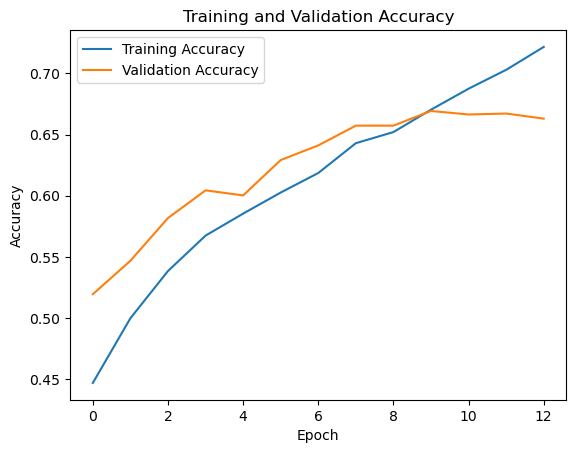

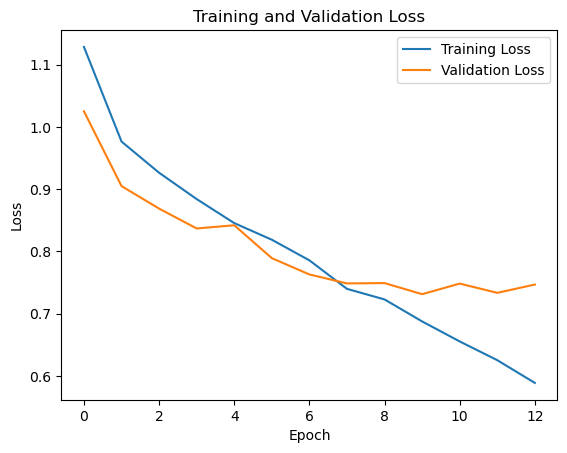

In [18]:
#그래프 코드
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# 정확도 그래프
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 손실률 그래프
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### [4] 평가
- 테스트 데이터 사용 => 입력 데이터의 형(shape) 설정

In [106]:
test2_path='../archive2/images/test/'

In [107]:
# 테스트 데이터 형성
test_gen =image_gen.flow_from_directory(test2_path,batch_size=128,
                                          color_mode='grayscale',
                                          target_size = (112,112),
                                          classes = ['angry','happy','sad'],
                                          class_mode = 'categorical',
                                          seed =2020)

Found 3979 images belonging to 3 classes.


In [108]:
test_gen

In [109]:
# 평가
score = model.evaluate(test_gen, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5513721108436584
Test accuracy: 0.7743151783943176


##### [5] 예측

In [110]:
np.set_printoptions(suppress=False, floatmode='fixed')

In [111]:
# 샘플 이미지 출력
class_labels = ['Angry','Happy','Sad']
batch = next(test_gen)
images,labels = batch[0],batch[1]
labels
y_pred = np.argmax(model.predict(test_gen), axis = -1)
print( len(y_pred), model.predict(test_gen))

32/32 [==============================] - 11s 347ms/step
3979 [[2.00392172e-01 4.55940187e-01 3.43667626e-01]
 [6.43200520e-03 9.91207600e-01 2.36038538e-03]
 [4.65195671e-06 9.99994636e-01 7.21953199e-07]
 ...
 [2.94512272e-01 3.94228131e-01 3.11259568e-01]
 [2.65956461e-01 2.12720543e-01 5.21322966e-01]
 [3.16206306e-01 3.82070780e-01 3.01722854e-01]]


In [112]:
images.shape, labels.shape, labels[:5], np.argmax(labels[:5], axis = -1), y_pred[:5]

((128, 112, 112, 1),
 (128, 3),
 array([[0.00000000, 1.00000000, 0.00000000],
        [1.00000000, 0.00000000, 0.00000000],
        [1.00000000, 0.00000000, 0.00000000],
        [0.00000000, 1.00000000, 0.00000000],
        [0.00000000, 1.00000000, 0.00000000]], dtype=float32),
 array([1, 0, 0, 1, 1], dtype=int64),
 array([1, 1, 0, 1, 1], dtype=int64))

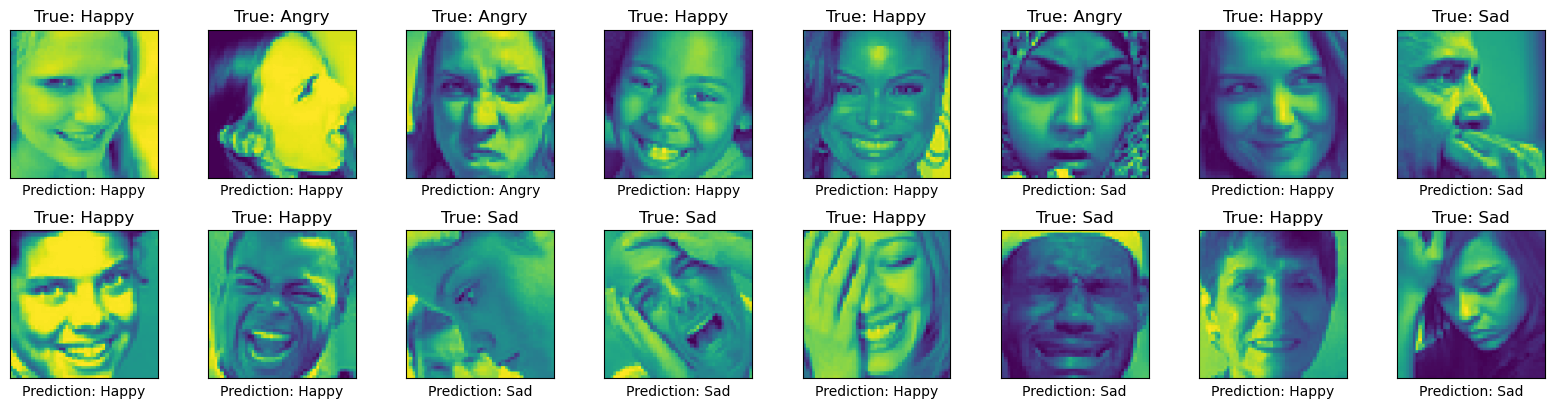

In [113]:
plt.figure(figsize=(16,8))
for i in range(16):

    ax = plt.subplot(4,8,i+1)
    plt.imshow(images[i])
    plt.xlabel(f'Prediction: {class_labels[y_pred[i]]}')
    plt.title('True: ' + class_labels[np.argmax(labels, axis = 1)[i]])
    plt.xticks([])
    plt.yticks([])
       
plt.tight_layout()
plt.show()

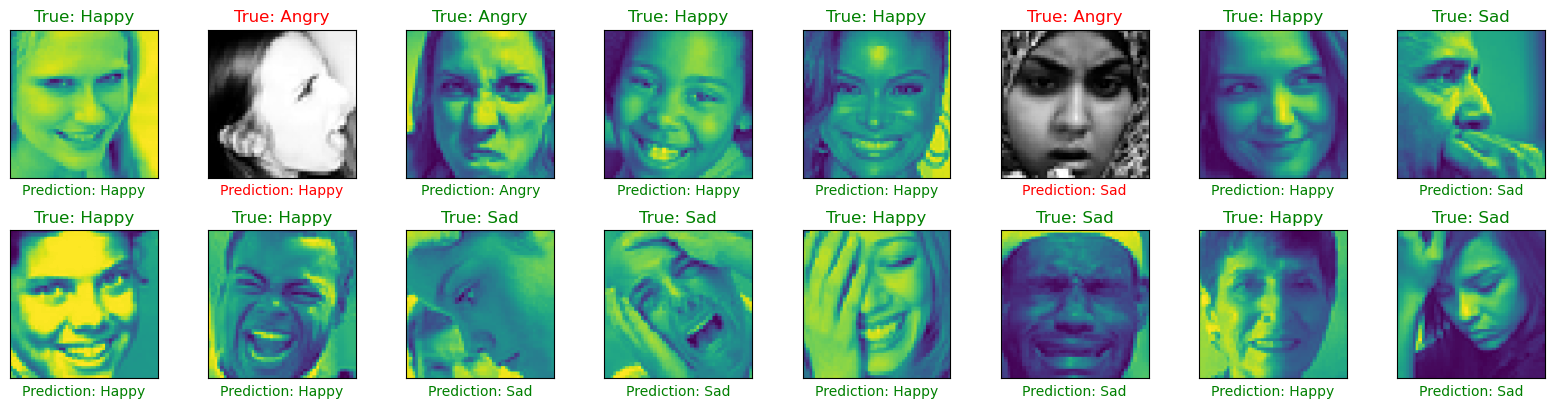

In [114]:
plt.figure(figsize=(16,8))
for i in range(16):

    ax = plt.subplot(4,8,i+1)
    
    plt.xticks([])  # remove x-axis ticks
    plt.yticks([])  # remove y-axis ticks
    
    # check if the true label is equal to the predicted label
    y_true = np.argmax(labels[i], axis=-1)
    if y_pred[i] == y_true:
        plt.imshow(images[i])  
        plt.xlabel(f'Prediction: {class_labels[y_pred[i]]}', color='green')
        plt.title('True: ' + class_labels[y_true], color='green')
    else:
        plt.imshow(images[i], cmap='gray')  # set the colormap to grayscale
        plt.xlabel(f'Prediction: {class_labels[y_pred[i]]}', color='red')
        plt.title('True: ' + class_labels[y_true], color='red')

plt.tight_layout()
plt.show()

In [115]:
model.save('face_expression.h5')